In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats

# Reflect Tables into SQLAlchemy ORM

In [20]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [23]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [26]:
# Use SQLAlchemy reflection to get the details of the Measurement table
inspector = inspect(engine)
measurement_columns = inspector.get_columns("measurement")
for c in measurement_columns:
    print(c["name"], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [27]:
# Use SQLAlchemy reflection to get the details of the Station table
station_columns = inspector.get_columns("station")
for c in station_columns:
    print(c["name"],c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [30]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

print(most_recent_date)

('2017-08-23',)


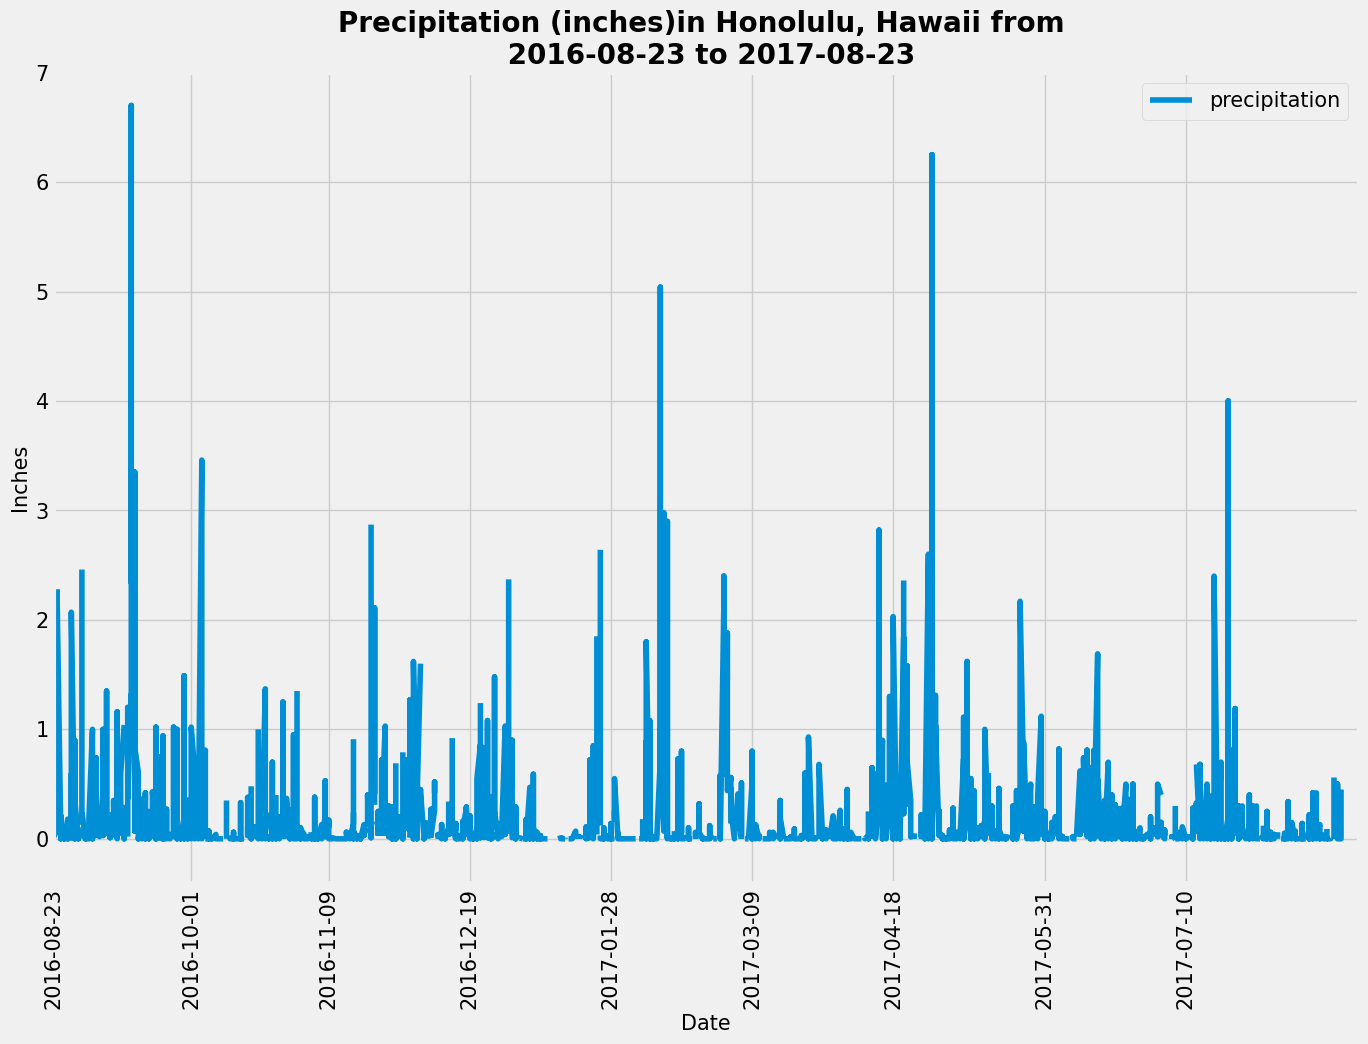

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
date_one_yr_ago_dt = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
query_date = date_one_yr_ago_dt.strftime('%Y-%m-%d') 

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_df = pd.DataFrame(last_year)
last_year_df = last_year_df.set_index("date")

# Sort the dataframe by date
sorted_df = last_year_df.sort_values(by = "date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15, 10))
plt.plot(sorted_df.index, sorted_df['prcp'])

# Add legned 
plt.legend(['precipitation'], loc="upper right",fontsize=15)
# set x location
xloc = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18','2017-05-31','2017-07-10'] 

# Assign xticks
plt.xticks(xloc, rotation='vertical',fontsize=15)
# Set Labels & Title
plt.xlabel('Date', fontsize=15)
plt.ylabel("Inches",fontsize=15)
plt.title(f"Precipitation (inches)in Honolulu, Hawaii from \n {query_date} to {last_date}",fontsize=20, fontweight = 'bold')
plt.yticks(size=15)

# Asign xlim and ylim
plt.xlim(0,370)
plt.ylim(-0.4,7)


# Save Figure
plt.savefig("Images/Precipitation_Plot.png", bbox_inches = 'tight')
# Show plot
plt.show()

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [33]:
# Design a query to calculcolumns = inspector.get_columns('station')
columns = inspector.get_columns('station')
session.query(Station.id).count()

9

In [34]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
ste = [Station.station, func.count(Measurement.station)]
session.query(*ste).filter(Station.station == Measurement.station).group_by(Station.station).\
                            order_by(func.count(Measurement.station).desc()).all()



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*sel).filter(Measurement.station == ste[0]).all()

[(53.0, 87.0, 73.09795396419437)]

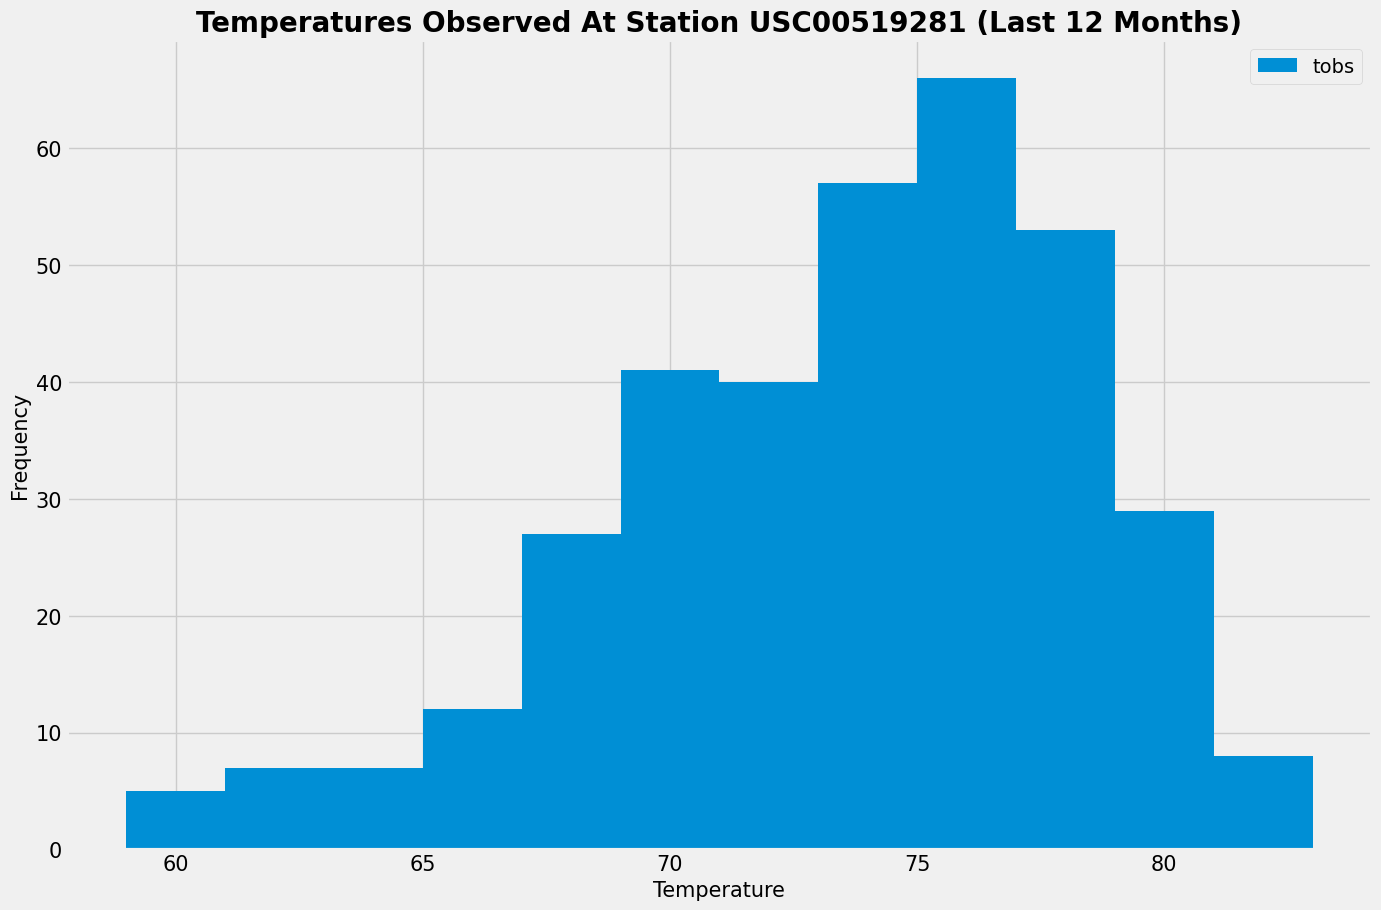

<Figure size 640x480 with 0 Axes>

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first() # 'USC00519281'
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.tobs).\
            filter(Measurement.date.between(query_date,last_date),\
                   Measurement.station == 'USC00519281').all()

# Plot the results as a histogram
plt.figure(figsize=(15,10))
plt.hist(np.ravel(results), bins=12)
plt.title('Temperatures Observed At Station USC00519281 (Last 12 Months)',fontsize=20, fontweight = 'bold')
plt.xlabel('Temperature',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend(['tobs'], loc = 'upper right')
plt.yticks(size=15)
plt.xticks(size=15)

# Save Figure
plt.savefig("Images/station_Plot.png")
# Show plot
plt.show()
plt.tight_layout()



# Close Session

In [16]:
# Close Session
session.close()